In [1]:
import torch
from tqdm import tqdm

In [2]:
# dataset is a shakespeare text in input.txt
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

def get_data():
    # data will be some text with characters and some newlines, roughly 1.1 million characters
    with open('input.txt', 'r', encoding='utf-8') as f:
        data = f.read()
    return data

In [3]:
text = get_data()
#['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A',
#'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 
#'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
#'d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
#'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch: i for i, ch in enumerate(chars)}
itos = { i: ch for i, ch in enumerate(chars)}
# for a string give a list of integers for each character in it
encode = lambda s: [stoi[ch] for ch in s]
# do the opposite
decode = lambda li: [itos[i] for i in li]

# convert all text into numbers
data = torch.tensor(encode(text), dtype=torch.long)
print(f"Data shape: {data.shape}, dtype: {data.dtype}")


Data shape: torch.Size([1115394]), dtype: torch.int64


### Split data

In [4]:
n = int(0.9 * len(data))
train_data= data[:n]
val_data = data[n:]

In [5]:
len(train_data), len(val_data)

(1003854, 111540)

In [6]:
context_length = 8 # I like context length more than block size


In [7]:
x= train_data[:context_length]
y = train_data[1:context_length+1]
for t in range(context_length):
    context = x[:t+1]
    target = y[t]
    print(f"Input: {context}, target: {target}")

Input: tensor([18]), target: 47
Input: tensor([18, 47]), target: 56
Input: tensor([18, 47, 56]), target: 57
Input: tensor([18, 47, 56, 57]), target: 58
Input: tensor([18, 47, 56, 57, 58]), target: 1
Input: tensor([18, 47, 56, 57, 58,  1]), target: 15
Input: tensor([18, 47, 56, 57, 58,  1, 15]), target: 47
Input: tensor([18, 47, 56, 57, 58,  1, 15, 47]), target: 58


In [8]:
torch.manual_seed(1337)

In [9]:
batch_size = 4
context_length = 8

def get_batch(split):
    data = train_data if split == 'train' else val_data
    # generate (batch_size,) indices that are in [0, len(data) - context_length]
    ix = torch.randint(len(data) - context_length, (batch_size,))
    # each ix gives one context in the batch
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

In [10]:
xb, yb = get_batch('train')

In [11]:
print(xb.shape, yb.shape)

torch.Size([4, 8]) torch.Size([4, 8])


In [12]:
print(f"Inputs: {xb}")

Inputs: tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [13]:
print(f"Targets: {yb}")

Targets: tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [14]:
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)

In [15]:
# basically given the current character, learn
# a probability distribution over the next characters.
# when you get new characters, lookup in the table to see what could come next
class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, inputs, targets=None):
        # get the logits 
        # # (Batch_size x Context length x (vocab_size/embedding dimension)
        logits = self.token_embedding_table(inputs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            # target are just indices of the next character.
            # In some sense T is just doing more complex batching
            # You could just unroll this to (BT, 1) input -> (BT, C) logits
            # and (BT) as target
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        # inputs is (B x context_length) and keeps increasing as you generate
        # probably this doesn't matter
        for _ in range(max_new_tokens):
            #print(inputs.shape)
            logits, loss = self(inputs)
            #print(logits.shape)
            # logits the last value will have the next token 
            # it is a bit moot to call is context, but we will expand on it 
            # i guess, with attention
            # get the prob dist of the last input in each batch
            logits = logits[:, -1, :]
            # apply softmax to get probabilits
            probs = F.softmax(logits, dim=-1) # still B x vocab_size
            # sample from the distribution to get the next character
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)%

            # append to th input
            inputs = torch.cat((inputs, idx_next), dim=1) # (B, context_length + 1)
        return inputs

In [38]:
model = BigramModel(vocab_size)

In [39]:
logits, loss = model(xb, yb)

In [40]:
loss

tensor(4.6829, grad_fn=<NllLossBackward0>)

In [41]:
new_input = model.generate(xb, max_new_tokens=10)

In [42]:
xb.shape

torch.Size([512, 8])

In [43]:
new_input.shape

torch.Size([512, 18])

In [44]:
print(''.join(decode(model.generate(inputs = torch.ones((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist())))


 NI&yH: RIDaV Fzo'xbkOJ-duOh;MeEmp$rinJ&gD?U$AltDNbin-&OAieq
S$mJPDt!ORtcxK.;yQnOypXfh;.$G:Om!J&HsFhO


In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [46]:
batch_size = 1024
losses =[]
for steps in tqdm(range(10000)):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print(loss.item())


100%|█████████████████████████████████████| 10000/10000 [04:05<00:00, 40.79it/s]

2.4715466499328613


In [48]:
print(''.join(decode(model.generate(inputs = 55*torch.ones((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist())))

qungeir higowire'shis he sthis;
Hed s ld mes,
PRourtham ce I y RENINGo whure the ivimeat tcenainouare


In [49]:
import matplotlib.pyplot as plt

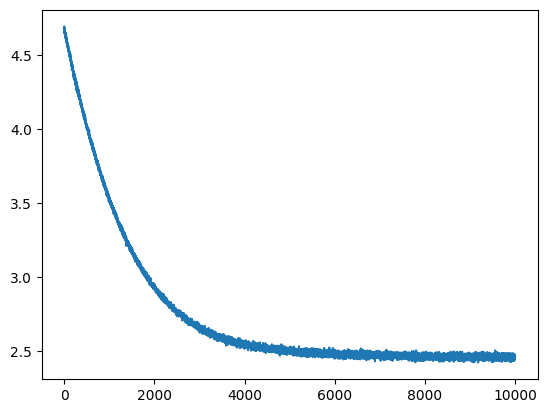

In [50]:
plt.plot(losses)

In [51]:
print(''.join(decode(model.generate(inputs = torch.ones((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist())))


 s.
ur brelinder llele resaparupoushais, gu w y sm, molaverabsolubr IOfe ch ha it sthe feaiss he may s fod
I y hepiocardse tht omofr l u cakederrs, in bunoridithe teeson me ur fabras T:


PO:
thits RE wifepossunack heme;
Thore aks f asandy ancath wicaprfay chouls:
KEME:
Whemoyout in t!
Theand hmuth eat.'sive ro Fout math moud yQUThy slimatinere'



FRI avimir f
Harn haveeinfonyinanimat wo afl he rd.GAneo y y.
LAppl con.

Haw
OS:

Thin non?
He edCO:
Sinisin'd the theay manl pr CKE f fastistane
Sed
